Данные по оборотам пунктов выдачи заказов (ПВЗ) усреднены помесячно за период с августа по октябрь 2023 г. 

Значения оборотов преобразованы с сохранением исходного распределения в целях защиты информации.

Выбраны только те ПВЗ, которые вышли на период зрелости (старше 6 месяцев), находятся в России, Беларуси, Казахстане и Армении.

## Files
- train.csv, test.csv: каждая строка - информация по отдельному ПВЗ с уникальным идентификатором, оборотом и дополнительными атрибутами.
- sample_submission.csv - a sample submission file in the correct format
- isochrones.gpkg: слой с изохронами (3, 5, 10, 15, 30 минут) от каждого ПВЗ. Загружен в отдельную ссылку, которая размещена в чате конкурса.

## Columns

**train.csv / test.csv**

- id - уникальный идентификатор
- sales_per_month - средний оборот за август, сентябрь, октябрь 2023 (целевая переменная)
- region - регион
- locality - населённый пункт
- x - долгота
- y - широта
- people_iso_3 - численность населения в 3-х минутной изохроне
- people_iso_5 - численность населения в 5-и минутной изохроне
- people_iso_10 - численность населения в 10-и минутной изохроне
- people_iso_15 - численность населения в 15-и минутной изохроне
- people_iso_30 - численность населения в 30-и минутной изохроне

**isochrones.gpkg**

- id - уникальный идентификатор
- iso_time - минута изохроны
- geom - геометрия изохроны

все изохроны строились по этой (https://github.com/romanovgleb/bafu/blob/cf6e999d1852d40f2050c2b95ec5c42f4670c477/bafu.py#L246) функции.

коротко:
* через osmnx выгружаем walkable граф сети
* строим коннектор до ближайшей точки ребра графа со скоростью 3.5 кмч
* рассчитываем время исходя из скорости пешехода 4.5 кмч
* строим для каждого временного отрезка ego_graph
* вокруг набора рёбер строим буфер
* возвращаем dissolved буфер

важно: есть fallback-механизм, при котором если для конкретного временного промежутка ego_graph не построился - берём то расстояние, которое мы прошли бы за это время, умножаем на 0.8, и возвращаем геометрию в виде буфера (концентрические круги на картинке - это оно)

поэтому в очень небольшом количестве случаев там, где признаки должны были иметь накопительный характер (например, в 5-минутной изохроне меньше ресторанов, чем 30-минутной), это правило может нарушаться

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.set_option('display.max_columns', None)
import geopandas as gpd
from shapely import Point, Polygon, MultiPolygon
import contextily as ctx

import mapclassify
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import Voronoi
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import pyproj
import math
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import defaultdict
from sklearn.neighbors import BallTree

In [3]:
PATH_PROJECT = '..'
PATH_DATA = f'{PATH_PROJECT}/data'

In [4]:
os.listdir(PATH_DATA)

['source']

In [5]:
os.listdir(f'{PATH_DATA}/source')

['isochrones.gpkg', 'test.csv', 'train.csv', 'sample_submission.csv']

In [6]:
df_sample_submission = pd.read_csv(f'{PATH_DATA}/source/sample_submission.csv')
df_train = pd.read_csv(f'{PATH_DATA}/source/train.csv')
df_test = pd.read_csv(f'{PATH_DATA}/source/test.csv')

In [8]:
display(df_sample_submission)
display(df_train)
display(df_test)

,id,sales_per_month
0,8319,12345.6
1,10248,12345.6
2,22502,12345.6
3,24497,12345.6
4,23685,12345.6
...,...,...
17426,18085,12345.6
17427,23428,12345.6
17428,11862,12345.6
17429,10382,12345.6


,id,sales_per_month,region,locality,x,y,people_iso_3,people_iso_5,people_iso_10,people_iso_15,people_iso_30
0,18398,2538.0,Челябинская область,Озерск,60.692229,55.761933,971,2093,10439,23027,73676
1,14532,1645.0,Москва,Москва,37.678559,55.702931,840,2329,15949,35836,67185
2,23801,3176.0,Липецкая область,Липецк,39.524007,52.589588,690,4012,22279,47864,163666
3,9791,4759.0,Краснодарский край,посёлок городского типа Сириус,39.957405,43.414255,49,515,2699,3710,9449
4,3004,2051.0,Тюменская область,Сургут,73.450188,61.237837,1416,5619,23135,50801,110709
...,...,...,...,...,...,...,...,...,...,...,...
8581,9396,2639.0,Тюменская область,Ноябрьск,75.438110,63.196350,486,2271,11123,24130,70181
8582,20106,2274.0,Московская область,Подольск,37.536210,55.421086,870,2170,12298,32230,89685
8583,7559,2156.0,Волгоградская область,Волжский,44.773472,48.769915,285,369,3396,12123,76280
8584,15471,1427.0,Минск,Минск,27.555579,53.921064,645,1735,11585,21950,89723


,id,region,locality,x,y,people_iso_3,people_iso_5,people_iso_10,people_iso_15,people_iso_30
0,8319,Московская область,Домодедово,37.762291,55.450032,470,506,1353,5967,53161
1,10248,Ростовская область,Таганрог,38.921404,47.270064,42,138,838,6112,38855
2,22502,Ростовская область,посёлок Матвеев Курган,38.859816,47.565717,18,60,524,2437,11424
3,24497,Москва,Москва,37.720271,55.597304,716,2917,12095,24653,111441
4,23685,Ростовская область,село Авило-Успенка,38.674475,47.692474,0,3,30,108,447
...,...,...,...,...,...,...,...,...,...,...
17426,18085,Московская область,Воскресенск,38.693206,55.310078,0,0,0,0,8053
17427,23428,Ереван,Ереван,44.525006,40.131853,838,1136,9215,20182,47220
17428,11862,Лорийская область,Ванадзор,44.483527,40.811495,1234,3135,15032,28339,48335
17429,10382,Ереван,Ереван,44.525365,40.207058,1942,5353,23017,51741,147016


In [9]:
df_train['split'] = 'train'
df_test['split'] = 'test'
df = pd.concat([df_train, df_test], sort=False, ignore_index=True)
df['point'] = df[['x', 'y']].apply(Point, axis=1)

In [10]:
df.isna().sum()

id                     0
sales_per_month    17431
region                 2
locality             209
x                      0
y                      0
people_iso_3           0
people_iso_5           0
people_iso_10          0
people_iso_15          0
people_iso_30          0
split                  0
point                  0
dtype: int64

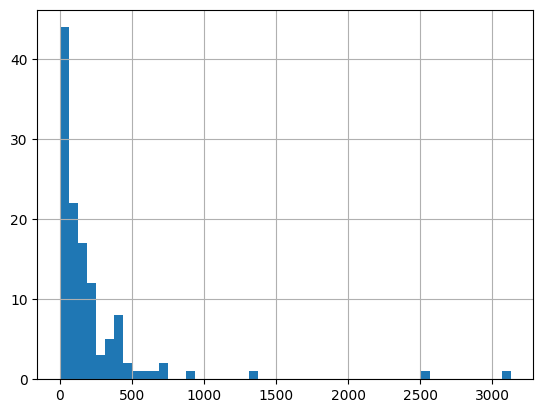

Московская область         3128
Москва                     2553
Краснодарский край         1365
Санкт-Петербург             905
Ростовская область          751
Тюменская область           739
Свердловская область        637
Республика Крым             597
Нижегородская область       547
Красноярский край           493
Самарская область           465
Республика Татарстан        430
Воронежская область         418
Иркутская область           412
Ленинградская область       410
Челябинская область         409
Ставропольский край         402
Новосибирская область       391
Пермский край               390
Республика Башкортостан     371
Саратовская область         350
Кемеровская область         344
Белгородская область        328
Волгоградская область       316
Тульская область            298
Алтайский край              260
Владимирская область        255
Калужская область           242
Оренбургская область        229
Минск                       225
Рязанская область           221
Брянская

In [17]:
counts = df['region'].value_counts()
counts.hist(bins=50)
plt.show()
counts.head(50)

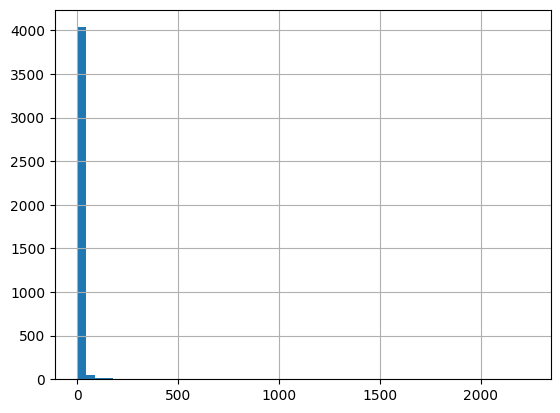

Москва             2235
Санкт-Петербург     745
Краснодар           364
Новосибирск         275
Ростов-на-Дону      254
Нижний Новгород     250
Воронеж             246
Красноярск          239
Екатеринбург        229
Минск               225
Самара              217
Балашиха            203
Тюмень              200
Казань              181
Пермь               174
Челябинск           171
Омск                169
Симферополь         158
Саратов             157
Волгоград           155
Уфа                 152
Севастополь         152
Иркутск             144
Сочи                142
Подольск            134
Рязань              129
Тула                115
Химки               115
Курск               114
Липецк              113
Барнаул             110
Белгород            108
Ярославль           108
Астрахань           105
Ставрополь          103
Ереван              101
Люберцы              99
Калуга               98
Ижевск               97
Кемерово             97
Брянск               94
Красногорск     

In [18]:
counts = df['locality'].value_counts()
counts.hist(bins=50)
plt.show()
counts.head(50)

выгружаем границы стран

In [19]:
file_name = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/geojson?lang=en&timezone=Europe%2FMinsk'
countries = gpd.read_file(file_name, driver = 'GeoJSON')

mask_rus = countries['name'].str.contains('Russ')
mask_bela = countries['name'].str.contains('Bela')
mask_kaz = countries['name'].str.contains('Kaz')
mask_arm = countries['name'].str.contains('Arm')

mask = mask_rus | mask_bela | mask_kaz | mask_arm                  
clms = ['name', 'iso3', 'geometry']
dic_rename = {
    'name' : 'country_name',
    'iso3' : 'country_code'
}
countries = countries.loc[mask, clms].rename(dic_rename, axis=1)

In [20]:
id2countries = gpd.GeoDataFrame(df[['id']].copy(), geometry=df['point'], crs=4326)
id2countries = id2countries.sjoin(countries)
dic_id2countries = id2countries.set_index('id')['country_code']
df['country_code'] = df['id'].map(dic_id2countries)

In [21]:
id2countries['id'].nunique(), df['id'].nunique()

(25147, 26017)

In [22]:
df.isna().sum()

id                     0
sales_per_month    17431
region                 2
locality             209
x                      0
y                      0
people_iso_3           0
people_iso_5           0
people_iso_10          0
people_iso_15          0
people_iso_30          0
split                  0
point                  0
country_code         870
dtype: int64

заполним пропуски для стран, регионов и городов на основании ближайших

In [23]:
df['region_nan'] = df['region'].isna().astype(int)
df['locality_nan'] = df['locality'].isna().astype(int)
df['country_code_nan'] = df['country_code'].isna().astype(int)

In [24]:
df['lon'] = df['x']
df['lat'] = df['y']

df['lon_rad'] = df['lon'].apply(np.deg2rad).values
df['lat_rad'] = df['lat'].apply(np.deg2rad).values

In [25]:
dic_id2region = df.set_index('id')['region'].to_dict()
dic_id2country_code = df.set_index('id')['country_code'].to_dict()
dic_id2locality = df.set_index('id')['locality'].to_dict()

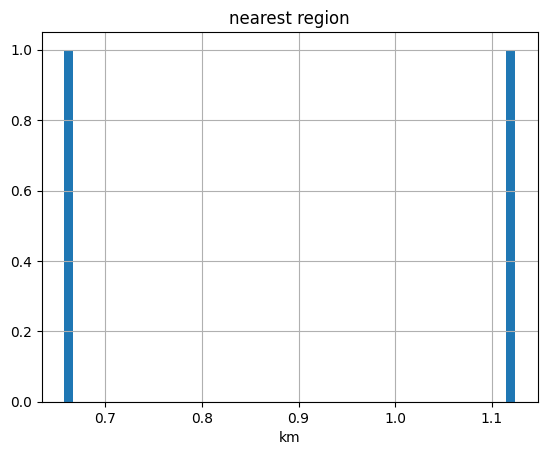

In [27]:
# пропуски по region
mask = df['region_nan'] == 1
ball = BallTree(df.loc[~mask, ["lat_rad", "lon_rad"]].values, metric='haversine')
dic_index2id = dict(enumerate(df.loc[~mask, 'id'].values))
distances, indices = ball.query(df.loc[mask, ["lat_rad", "lon_rad"]].values, k = 1)
df.loc[mask, 'region'] = list(map(dic_id2region.get, map(dic_index2id.get, indices.squeeze())))

ax = pd.Series(distances.squeeze()* 6371).hist(bins=50)
ax.set_title('nearest region')
ax.set_xlabel('km');

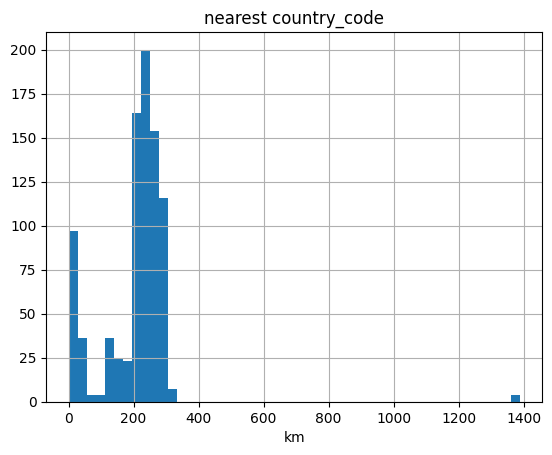

In [28]:
# пропуски по country_code
mask = df['country_code_nan'] == 1
ball = BallTree(df.loc[~mask, ["lat_rad", "lon_rad"]].values, metric='haversine')
dic_index2id = dict(enumerate(df.loc[~mask, 'id'].values))
distances, indices = ball.query(df.loc[mask, ["lat_rad", "lon_rad"]].values, k = 1)
df.loc[mask, 'country_code'] = list(map(dic_id2country_code.get, map(dic_index2id.get, indices.squeeze())))

ax = pd.Series(distances.squeeze()* 6371).hist(bins=50)
ax.set_title('nearest country_code')
ax.set_xlabel('km');

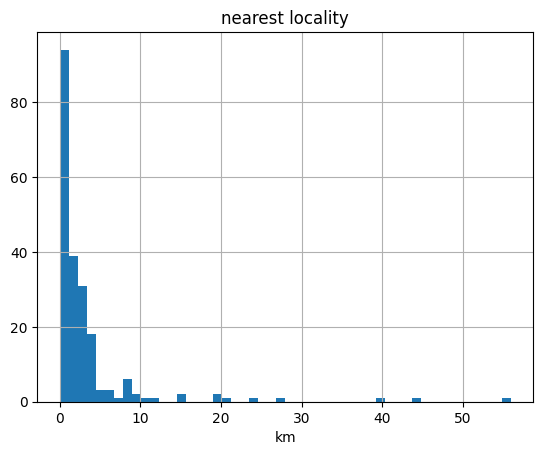

In [29]:
# пропуски по locality
mask = df['locality_nan'] == 1
ball = BallTree(df.loc[~mask, ["lat_rad", "lon_rad"]].values, metric='haversine')
dic_index2id = dict(enumerate(df.loc[~mask, 'id'].values))
distances, indices = ball.query(df.loc[mask, ["lat_rad", "lon_rad"]].values, k = 1)
df.loc[mask, 'locality'] = list(map(dic_id2locality.get, map(dic_index2id.get, indices.squeeze())))

ax = pd.Series(distances.squeeze()* 6371).hist(bins=50)
ax.set_title('nearest locality')
ax.set_xlabel('km');

In [30]:
df.isna().sum()

id                      0
sales_per_month     17431
region                  0
locality                0
x                       0
y                       0
people_iso_3            0
people_iso_5            0
people_iso_10           0
people_iso_15           0
people_iso_30           0
split                   0
point                   0
country_code            0
region_nan              0
locality_nan            0
country_code_nan        0
lon                     0
lat                     0
lon_rad                 0
lat_rad                 0
dtype: int64

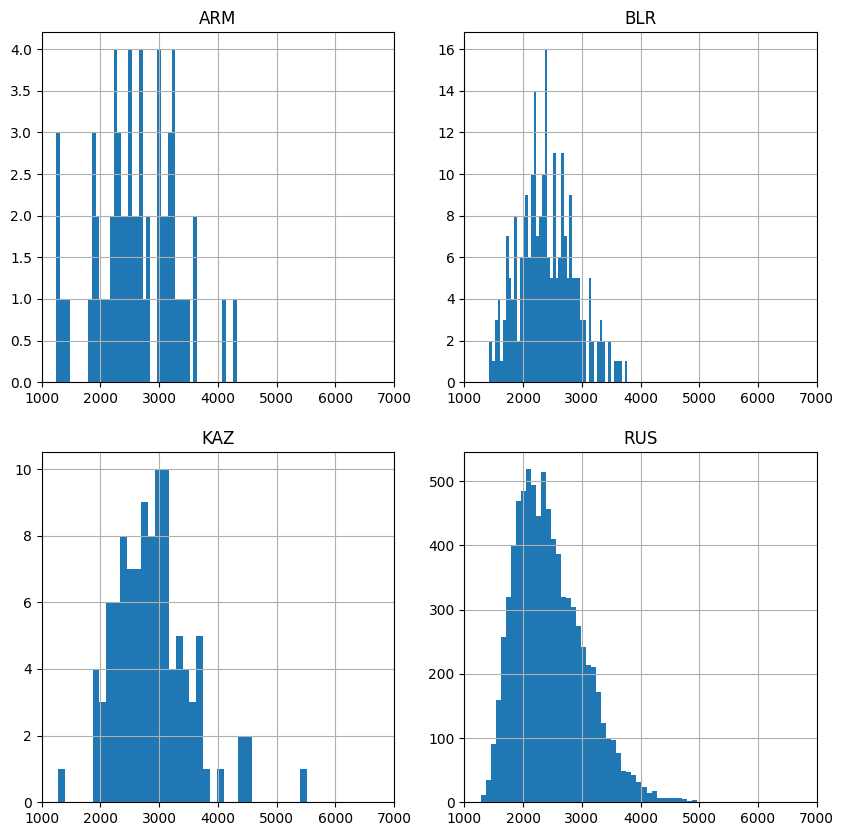

In [31]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
for ax, (country_code, subset) in zip(axes, df.groupby('country_code')):
    subset['sales_per_month'].hist(bins=50, ax=ax)
    ax.set_title(country_code)
    ax.set_xlim((1000, 7000))
plt.show()

In [34]:
df[mask_train]['region'].value_counts()

Московская область                          1073
Москва                                       829
Краснодарский край                           453
Санкт-Петербург                              312
Тюменская область                            275
                                            ... 
Кызылординская область                         1
город республиканского значения Байконур       1
область Жетысу                                 1
Чукотский автономный округ                     1
Туркестанская область                          1
Name: region, Length: 119, dtype: int64

In [35]:
df[~mask_train]['region'].value_counts()

Московская область                          2055
Москва                                      1724
Краснодарский край                           912
Санкт-Петербург                              593
Ростовская область                           493
                                            ... 
город республиканского значения Байконур       2
Тавушская область                              2
Вайоцдзорская область                          1
область Жетысу                                 1
Жамбылская область                             1
Name: region, Length: 119, dtype: int64

In [36]:
df[mask_train]['locality'].value_counts()

Москва              735
Санкт-Петербург     261
Краснодар           115
Ростов-на-Дону       91
Новосибирск          90
                   ... 
посёлок Птичное       1
Севан                 1
деревня Крючково      1
Калинковичи           1
Харабали              1
Name: locality, Length: 2202, dtype: int64

In [37]:
df[~mask_train]['locality'].value_counts()

Москва                           1525
Санкт-Петербург                   484
Краснодар                         249
Новосибирск                       185
Нижний Новгород                   175
                                 ... 
Кораблино                           1
станица Новоалексеевская            1
деревня Касимово                    1
рабочий посёлок Магистральный       1
деревня Терпилицы                   1
Name: locality, Length: 3337, dtype: int64

в некоторых городах и регионах по одному ПВЗ, объединим с теми, где хотябы больше 10

In [38]:
mask_train = df['split'] == 'train'

In [39]:
list_region_train = df[mask_train]['region'].value_counts()
list_region_train = list_region_train[list_region_train < 10].index.tolist()
list_region_test = df[~mask_train]['region'].value_counts()
list_region_test = list_region_test[list_region_test < 10].index.tolist()
list_region = list_region_train + list_region_test

list_locality_train = df[mask_train]['locality'].value_counts()
list_locality_train = list_locality_train[list_locality_train < 10].index.tolist()
list_locality_test = df[~mask_train]['locality'].value_counts()
list_locality_test = list_locality_test[list_locality_test < 10].index.tolist()
list_locality = list_locality_train + list_locality_test

In [40]:
new_df = []

for country_code, subset in df.groupby('country_code'):

    # пропуски по region
    subset['region_new'] = subset['region']
    mask = (subset['region_nan'] == 1) | (subset['region'].isin(list_region))
    if mask.sum():
        ball = BallTree(subset.loc[~mask, ["lat_rad", "lon_rad"]].values, metric='haversine')
        dic_index2id = dict(enumerate(subset.loc[~mask, 'id'].values))
        distances, indices = ball.query(subset.loc[mask, ["lat_rad", "lon_rad"]].values, k = 1)
        subset.loc[mask, 'region_new'] = list(map(dic_id2region.get, map(dic_index2id.get, indices.squeeze())))
        
        
    # пропуски по locality
    subset['locality_new'] = subset['locality']
    mask = (subset['locality_nan'] == 1) | (subset['locality'].isin(list_locality))
    if mask.sum():
        ball = BallTree(subset.loc[~mask, ["lat_rad", "lon_rad"]].values, metric='haversine')
        dic_index2id = dict(enumerate(subset.loc[~mask, 'id'].values))
        distances, indices = ball.query(subset.loc[mask, ["lat_rad", "lon_rad"]].values, k = 1)
        subset.loc[mask, 'locality_new'] = list(map(dic_id2locality.get, map(dic_index2id.get, indices.squeeze())))
    
    new_df.append(subset)
    
new_df = pd.concat(new_df, sort=False, ignore_index=True)

In [42]:
new_df.head()

,id,sales_per_month,region,locality,x,y,people_iso_3,people_iso_5,people_iso_10,people_iso_15,people_iso_30,split,point,country_code,region_nan,locality_nan,country_code_nan,lon,lat,lon_rad,lat_rad,region_new,locality_new
0,12017,4319.0,Ереван,Ереван,44.506717,40.183325,2225,9813,46619,82626,204850,train,POINT (44.506717 40.183325),ARM,0,0,0,44.506717,40.183325,0.776789,0.701331,Ереван,Ереван
1,752,3051.0,Тавушская область,Иджеван,45.145217,40.876984,136,454,3109,5073,12402,train,POINT (45.145217 40.876984),ARM,0,0,0,45.145217,40.876984,0.787933,0.713438,Ереван,Ереван
2,23380,3595.0,Ширакская область,Гюмри,43.849544,40.787234,415,1652,9954,17735,48881,train,POINT (43.849544 40.787234),ARM,0,0,0,43.849544,40.787234,0.765319,0.711872,Ереван,Армавир
3,11961,1863.0,Ереван,Ереван,44.524595,40.217565,1346,2071,2762,6139,68512,train,POINT (44.524595 40.217565),ARM,0,0,0,44.524595,40.217565,0.777101,0.701929,Ереван,Ереван
4,18307,2833.0,Ширакская область,Гюмри,43.832584,40.828846,749,3396,14809,26917,33478,train,POINT (43.832584 40.828846),ARM,0,0,0,43.832584,40.828846,0.765023,0.712598,Ереван,Армавир


In [44]:
new_df.to_pickle(f'{PATH_DATA}/processed/df.pickle')